<a target="_blank" href="https://colab.research.google.com/github/heechul/DeepPicar-v3/blob/devel/RunAll.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

In [621]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import math
# from skimage import data
from skimage import io
from skimage.exposure import match_histograms

In [622]:
print(tf.__version__)

use_int8 = True  # use int8 input tensor
print("use_int8: ", use_int8)

2.14.0
use_int8:  True


In [623]:
# input image resolution to the DNN model (smaller than the original dataset image resolution: 320x240x3)
img_width = 80
img_height = 60
img_channels = 3

model_name = "model_opt"
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)

In [624]:
import requests 
import os
import zipfile

dataset_dir = "dataset"
dataset_zipfile = 'labtrack-leftonly-RTCSA22.zip' # 'Dataset-kucsl-Aug2022-zero.zip' # 'labtrack-leftonly-RTCSA22.zip' # 'Dataset.zip'
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = False

if RunningInCOLAB: 
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        dataset_zipfile = fn  # expecting a zip file to be uploaded. 
else:
    print ("not in colab")
    # RPI_IP=None # replace this with the IP address of your raspberry pi 
    # if RPI_IP is not None:
    #     URL="http://"+RPI_IP+":8000/"+dataset_zipfile
    #     filename=URL.split('/')[-1]
    #     r = requests.get(URL)
    #     open(filename, 'wb').write(r.content)

# if not os.path.isfile(dataset_zipfile):
#     default_dataset_URL = "https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip"    
#     print ("No existing dataset. download from ", default_dataset_URL)
#     r = requests.get(default_dataset_URL)
#     open(dataset_zipfile, 'wb').write(r.content)

if not os.path.isdir(dataset_dir) or force_unzip==True:
    print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    zip_ref = zipfile.ZipFile(dataset_zipfile)
    zip_ref.extractall(dataset_dir)

not in colab


In [625]:
# Train/test data lists
imgs = []
vals = []

def rad2deg(rad):
    return 180.0 * rad / math.pi
def deg2rad(deg):
    return math.pi * deg / 180.0

# Scale the image to the model input size
def get_image_resize(img):
    orig_h, orig_w, _ = img.shape
    scaled_img = cv2.resize(img, (img_width, img_height))
    return scaled_img

# Crop the image to the model input size
def get_image_crop(img):
    orig_h, orig_w, _ = img.shape
    startx = int((orig_w - img_width) * 0.5); # crop from both sides
    starty = int((orig_h - img_height) * 0.75); # crop from bottom
    return img[starty:starty+img_height, startx:startx+img_width,:]

def preprocess(img):
    img = get_image_resize(img)
    # Convert to grayscale and readd channel dimension
    if img_channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.reshape(img, (img_height, img_width, img_channels))
    if use_int8 == True:
        img = (img - 128).astype(np.int8)
    else:
        img = img.astype(np.float32) / 255.0
    return img

import glob
for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
    csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
    print(vid_file_path, csv_file_path)
    vid = cv2.VideoCapture(vid_file_path)
    df = read_csv(csv_file_path)

    for val in df["wheel"].values:
        ret,img = vid.read()
        img = preprocess(img)
        imgs.append(img)
        vals.append(val)
    print(len(imgs), len(vals))

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))

dataset/out-video-t80-n4.avi dataset/out-key-t80-n4.csv
1000 1000
dataset/out-video-t80-n1.avi dataset/out-key-t80-n1.csv
2000 2000
dataset/out-video-t80-n3.avi dataset/out-key-t80-n3.csv
3000 3000
dataset/out-video-t80-n2.avi dataset/out-key-t80-n2.csv
4000 4000
Loaded 4000 smaples


In [626]:
# Split the dataset for train and test 
print("Train/Test")
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.35)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

print("class_weights", class_weights)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
print("class_weights", class_weights)


Train/Test
class_weights [1.52046784 0.62530063 1.34575569]
class_weights {0: 1.5204678362573099, 1: 0.6253006253006252, 2: 1.3457556935817805}


In [627]:
len(x_train)

2600

In [628]:
from keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# original model
model = tf.keras.Sequential()
model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
if img_width >= 160:
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
else:
    model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, name="output", activation='tanh'))

model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_173 (Conv2D)         (None, 28, 38, 24)        1824      
                                                                 
 conv2d_174 (Conv2D)         (None, 12, 17, 36)        21636     
                                                                 
 conv2d_175 (Conv2D)         (None, 4, 7, 48)          43248     
                                                                 
 conv2d_176 (Conv2D)         (None, 2, 5, 64)          27712     
                                                                 
 conv2d_177 (Conv2D)         (None, 1, 4, 64)          16448     
                                                                 
 flatten_32 (Flatten)        (None, 256)               0         
                                                                 
 dense_96 (Dense)            (None, 100)             

In [629]:
print("Quantize Model")
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

print ("Model compile")
q_aware_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(3e-4),
		                loss=tf.keras.losses.MeanSquaredError())
q_aware_model.summary()

Quantize Model
Model compile
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_33 (Quantiz  (None, 60, 80, 3)         3         
 eLayer)                                                         
                                                                 
 quant_conv2d_173 (Quantize  (None, 28, 38, 24)        1875      
 WrapperV2)                                                      
                                                                 
 quant_conv2d_174 (Quantize  (None, 12, 17, 36)        21711     
 WrapperV2)                                                      
                                                                 
 quant_conv2d_175 (Quantize  (None, 4, 7, 48)          43347     
 WrapperV2)                                                      
                                                                 
 quant_conv2d_176 (Quant

Model fit
Epoch 1/20
11/11 [==============================] - 3s 135ms/step - loss: 0.1482 - val_loss: 0.1025
Epoch 2/20
11/11 [==============================] - 1s 120ms/step - loss: 0.0966 - val_loss: 0.0829
Epoch 3/20
11/11 [==============================] - 1s 112ms/step - loss: 0.0697 - val_loss: 0.0670
Epoch 4/20
11/11 [==============================] - 1s 119ms/step - loss: 0.0534 - val_loss: 0.0595
Epoch 5/20
11/11 [==============================] - 1s 111ms/step - loss: 0.0436 - val_loss: 0.0469
Epoch 6/20
11/11 [==============================] - 1s 117ms/step - loss: 0.0346 - val_loss: 0.0448
Epoch 7/20
11/11 [==============================] - 1s 111ms/step - loss: 0.0317 - val_loss: 0.0406
Epoch 8/20
11/11 [==============================] - 1s 112ms/step - loss: 0.0261 - val_loss: 0.0356
Epoch 9/20
11/11 [==============================] - 1s 110ms/step - loss: 0.0217 - val_loss: 0.0360
Epoch 10/20
11/11 [==============================] - 1s 109ms/step - loss: 0.0197 - val_lo

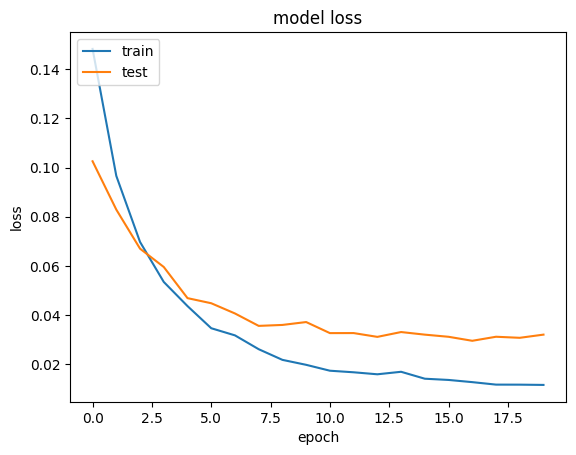

In [630]:
print ("Model fit")
# q_aware_model.reset_states()
history = q_aware_model.fit(x_train, y_train, batch_size=256,
                    epochs=20 , validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

In [631]:
angle_thresh=10
# Helper functions for evaluating model accuracy

def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < angle_thresh and degree > -angle_thresh:
    return "center"
  elif degree >= angle_thresh:
    return "right" 
  elif degree <-angle_thresh:
    return "left"

pred_angle = q_aware_model.predict(x_test)
pred = np.array(list(map(get_action, pred_angle)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))

44/44 [==============================] - 0s 6ms/step
Accuracy is 0.849


visualization

In [632]:
def plot_image(i, prediction_array, groundtrue_array, img_array):
  angle, predicted_label, groundtrue_label, img = int(rad2deg(pred_angle[i])), prediction_array[i], groundtrue_array[i], img_array[i]
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  if use_int8 == True:
    img = np.round((img + 128.0) / 255.0, 2)
  else:
    img = np.squeeze(img)
  plt.imshow(img, cmap=plt.cm.binary)
  if predicted_label == groundtrue_label:
    color = 'green'
  else:
    color = 'red'  
  plt.xlabel("Predict:{} ({}) Actual:{}".format(predicted_label,angle,groundtrue_label), color=color)

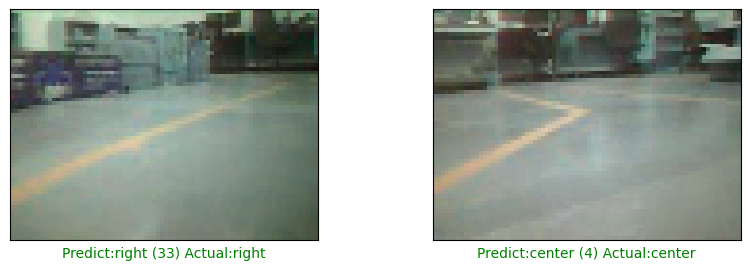

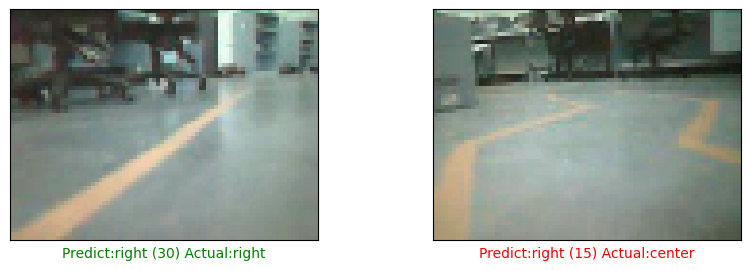

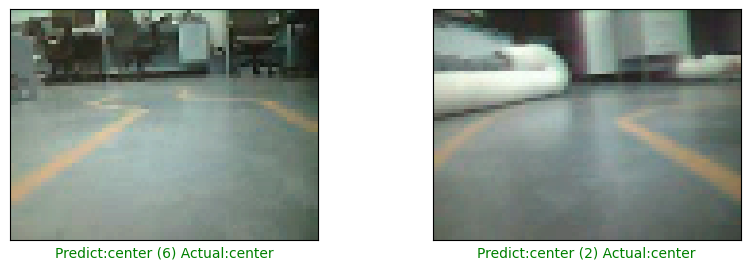

In [633]:
#@title Visualize the outputs { run: "auto" }
index = 100 #@param {type:"slider", min:0, max:244, step:6}
for i in range(3):
  plt.figure(figsize=(10,3))
  plt.subplot(1,2,1)
  plot_image(index + 2*i, pred, ground, x_test)
  plt.subplot(1,2,2)
  plot_image(index + 2*i+1, pred, ground, x_test)
  plt.show()

generate image cpp files for testing

In [634]:
# Save both the Keras and TFLite models      
print("Model Save")                  
q_aware_model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

print("Using int8 quantization")

quantized_tflite_model = converter.convert()

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")

Model Save
TFLite Model
Using int8 quantization


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmprd6yzdbc/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmprd6yzdbc/assets
/opt/homebrew/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-26 13:44:06.339087: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.


models/opt-80x60x3.tflite is saved. copy this file to the robot


2023-11-26 13:44:06.339290: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-26 13:44:06.339687: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmprd6yzdbc
2023-11-26 13:44:06.342938: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-26 13:44:06.342945: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmprd6yzdbc
2023-11-26 13:44:06.354243: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-26 13:44:06.476023: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmprd6yzdbc
2023-11-26 13:44:06.511571: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took

generate cc file from tflite model

In [635]:
!xxd -n gmodel -i {model_file}.tflite > {model_file}.cc
print ("models/"+model_file[7:]+".cc --> src/model.h")
!cat {model_file}.cc | sed "s/unsigned/const unsigned/g" > src/model.h

models/opt-80x60x3.cc --> src/model.h


[0.57855654]
Predicted: right (rad:[0.57855654], deg:[33.148846])
Actual:  right


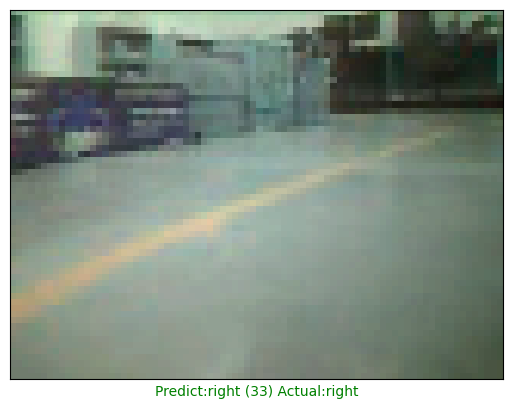

In [636]:
idx=100
img = x_test[idx]
# Write a C source file of the image for debugging purposes (to check if the model output is correct)
with open('src/img.h', 'w') as f:
    f.write('#ifndef IMG_TEST_DATA\n')
    f.write('#define IMG_TEST_DATA\n')
    f.write('const signed char img_data[] = {')
    for i in range(0, len(img.flatten())):
        f.write(str(img.flatten()[i]))
        if i < len(img.flatten()) - 1:
            f.write(',')    
    f.write('};\n')
    f.write('#endif\n')

plot_image(idx, pred, ground, x_test)
print(pred_angle[idx])
print("Predicted: {} (rad:{}, deg:{})".format(get_action(pred_angle[idx]), pred_angle[idx], rad2deg(pred_angle[idx])))
print("Actual: ", get_action(y_test[idx]))
plt.show()

### Inference

In [637]:
print("test img idx: {}, shape: {}".format(idx, img.shape))
print(img.flatten())

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, np.expand_dims(img, axis=0))

input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

interpreter.invoke()
q = interpreter.get_tensor(output_index)[0][0]
scale = interpreter.get_output_details()[0]['quantization_parameters']['scales'][0]
zero_point = interpreter.get_output_details()[0]['quantization_parameters']['zero_points'][0]
print('scale, zero_point: ', scale, zero_point)
angle = (q - zero_point) * scale
print("Predicted: {} (q:{}, rad:{}, deg:{})".format(get_action(angle), q, angle, rad2deg(angle)))

test img idx: 100, shape: (60, 80, 3)
[-11  25   0 ... -55 -45 -64]
input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>
scale, zero_point:  0.0078125 0
Predicted: right (q:74, rad:0.578125, deg:33.124122531000715)


In [638]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
scale = interpreter.get_output_details()[0]['quantization_parameters']['scales'][0]
zero_point = interpreter.get_output_details()[0]['quantization_parameters']['zero_points'][0]

pred_angle_q = []
for img in x_test:
    interpreter.set_tensor(input_index, np.expand_dims(img, axis=0))
    interpreter.invoke()
    q = interpreter.get_tensor(output_index)[0][0]
    angle = (q - zero_point) * scale
    pred_angle_q.append(angle)

pred_q = np.array(list(map(get_action, pred_angle_q)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred_q == ground))
print('float vs. quantized model same prediction prob: %.3f' % np.mean(pred_q == pred))

Accuracy is 0.850
float vs. quantized model same prediction prob: 0.991
